In [1]:
import align.detect_face

In [17]:
from align.facenet import get_dataset

In [18]:
dataset = get_dataset(paths='data/CASIA-WebFace/')

# take a look of the data

In [13]:
sum(len(i.image_paths) for i in dataset)

494414

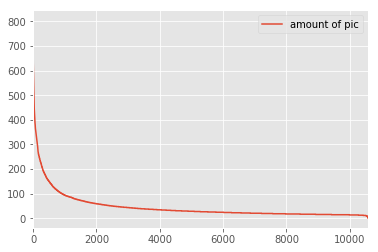

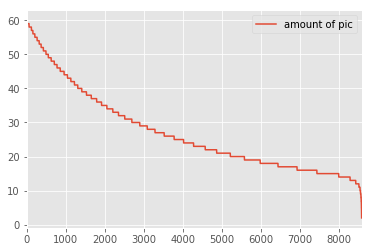

In [34]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
pd.DataFrame({'amount of pic':sorted([len(i.image_paths) for i in dataset],reverse=True)}).plot()
pd.DataFrame({'amount of pic':sorted([len(i.image_paths) for i in dataset],reverse=True)[2000:]}).plot()

In [16]:
max(len(i.image_paths) for i in dataset)

804

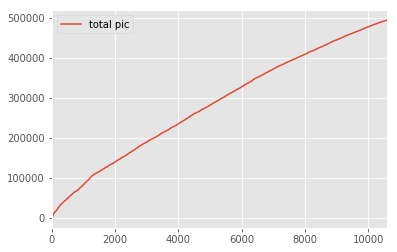

In [35]:
damount = [len(i.image_paths) for i in dataset]
for i in range(len(damount) - 1):
    damount[i + 1] += damount[i]
pd.DataFrame({'total pic':damount}).plot()

# test the image align technique

In [2]:
import align.detect_face
from scipy import misc
import tensorflow as tf
from matplotlib import pyplot as plt
plt.style.use('ggplot')

## use mtcnn

In [3]:
import align.align_dlib

In [5]:
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [6]:
with session.as_default():
    pnet, rnet, onet = align.detect_face.create_mtcnn(session, None)

## use dlib

In [7]:
align_tool = align.align_dlib.AlignDlib('data/shape_predictor_68_face_landmarks.dat')

In [102]:
landmarkIndices = align.align_dlib.AlignDlib.OUTER_EYES_AND_NOSE

In [103]:
landmarkIndices

[36, 45, 33]

## use opencv

In [9]:
facecascade = cv2.CascadeClassifier('data/haar_cascade_frontalface_default.xml')

## define some functions

In [10]:
from align.align_dlib import TEMPLATE,MINMAX_TEMPLATE
OUTER_EYES_AND_NOSE = [36, 45, 33]
landmarkIndices = OUTER_EYES_AND_NOSE
def align_pic(left,top,right,bottom,img,scale=0.78,imgDim=110):
    left = np.long(left)
    top = np.long(top)
    right = np.long(right)
    bottom = np.long(bottom)
    bb = dlib.rectangle(left,top,right,bottom)
    landmarks = align_tool.findLandmarks(img,bb)
    npLandmarks = np.float32(landmarks)
    npLandmarkIndices = np.array(landmarkIndices)
    H = cv2.getAffineTransform(npLandmarks[npLandmarkIndices],
                               imgDim * MINMAX_TEMPLATE[npLandmarkIndices]*scale + imgDim*(1-scale)/2)
    thumbnail = cv2.warpAffine(img, H, (imgDim, imgDim))
    return thumbnail

In [11]:
def margin_pic(img,l,t,r,b,margin=44,image_size=182):
    bb = np.zeros(4, dtype=np.int32)
    avglr = int((l + r) / 2)
    avgtb = int((t + b) / 2)
    r_cir = int(max((r - l),(b - t) )/ 2)
    bb[0] = np.maximum(l-margin/2, 0)
    bb[1] = np.maximum(t-margin/2, 0)
    bb[2] = np.minimum(r+margin/2, img.shape[1])
    bb[3] = np.minimum(b+margin/2, img.shape[0])
    
    #bb[0] = np.maximum(avglr - r_cir - margin/2, 0)
    #bb[1] = np.maximum(avgtb - r_cir -margin/2, 0)
    #bb[2] = np.minimum(avglr + r_cir + margin/2, img.shape[1])
    #bb[3] = np.minimum(avgtb + r_cir + margin/2, img.shape[0])
    cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
    scaled = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
    return scaled

In [12]:
def get_center_margin_ares(cord,img,margin=100,image_size=50):
    bb = np.zeros(4, dtype=np.int32)
    bb[0] = np.maximum(cord[0]-margin/2, 0)
    bb[1] = np.maximum(cord[1]-margin/2, 0)
    bb[2] = np.minimum(cord[0]+margin/2, img.shape[1])
    bb[3] = np.minimum(cord[1]+margin/2, img.shape[0])
    cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
    scaled = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
    return scaled

def get_landmark_centred_pic(left,top,right,bottom,img,margin=None):
    left = np.long(left)
    top = np.long(top)
    right = np.long(right)
    bottom = np.long(bottom)
    if margin is None:
        margin = min(right - left,bottom - top) * 0.83
    bb = dlib.rectangle(left,top,right,bottom)
    landmarks = align_tool.findLandmarks(img,bb)
    npLandmarks = np.float32(landmarks)
    npLandmarkIndices = np.array(landmarkIndices)
    landmarks = npLandmarks[npLandmarkIndices]
    return map(lambda x:get_center_margin_ares(x,img,margin=margin),landmarks)
    
    

## now run all those detectors

In [82]:
sample_file = dataset[150].image_paths[3]
sample_file = 'sample/mmexport1474478436146.jpg'
sample_img = misc.imread(sample_file)
sample_img.shape

(810, 1080, 3)

In [83]:
threshold = [ 0.6, 0.7, 0.7 ]
factor = 0.709 # scale factor
bounding_boxes, _ = align.detect_face.detect_face(sample_img,250, pnet,rnet,onet,threshold,factor)

In [84]:
aligned = align_tool.align(110, sample_img, landmarkIndices=landmarkIndices,skipMulti=False)
dlib_bounders = align_tool.getAllFaceBoundingBoxes(sample_img)

In [85]:
faces = facecascade.detectMultiScale(sample_img,scaleFactor=1.1,minNeighbors=5)

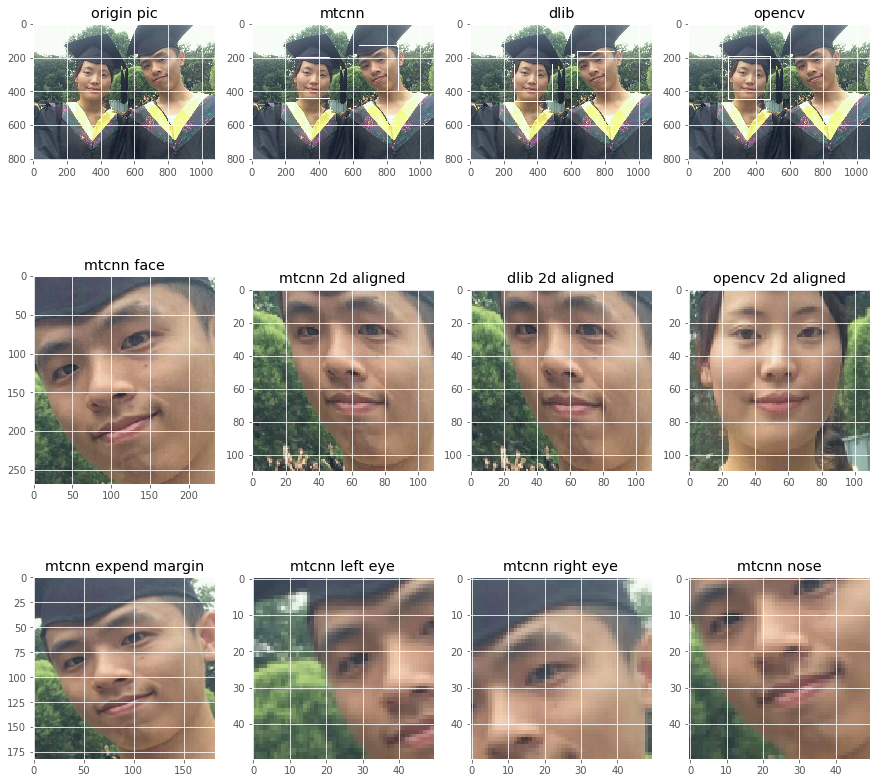

In [86]:
import cv2
import numpy as np
import dlib
plt.figure(figsize=(15,15))
img_mtnn = sample_img.copy()
img_cv2 = sample_img.copy()
img_dlib = sample_img.copy()

for i_mtnn in np.asarray(bounding_boxes,dtype=np.int):
    img_mtnn = cv2.rectangle(img_mtnn,(i_mtnn[0],i_mtnn[1]),(i_mtnn[2],i_mtnn[3]),(255,255,255),4)
for i_dlib in dlib_bounders:
    img_dlib = cv2.rectangle(img_dlib,(i_dlib.left(),i_dlib.top()),(i_dlib.right(),i_dlib.bottom()),(255,255,255),4)
for i_cv2 in np.asarray(faces,dtype=np.int):
    img_cv2 = cv2.rectangle(img_cv2,(i_cv2[0],i_cv2[1]),(i_cv2[0] + i_cv2[2],i_cv2[1] + i_cv2[3]),(255,255,255),4)
    
    
plt.subplot(3,4,1)
plt.imshow(sample_img)
plt.title('origin pic')
plt.subplot(3,4,2)
if bounding_boxes is not None:
    plt.imshow(img_mtnn)
    plt.title('mtcnn')
plt.subplot(3,4,3)
if dlib_bounders is not None:
    plt.imshow(img_dlib)
    plt.title('dlib')
plt.subplot(3,4,4)
if len(faces) > 0:
    plt.imshow(img_cv2)
    plt.title('opencv')


plt.subplot(3,4,5)
if len(bounding_boxes) > 0:
    plt.imshow(sample_img[i_mtnn[1]:i_mtnn[3],i_mtnn[0]:i_mtnn[2]])
    plt.title('mtcnn face')
plt.subplot(3,4,6)
if len(bounding_boxes) > 0:
    plt.imshow(align_pic(i_mtnn[0],i_mtnn[1],i_mtnn[2],i_mtnn[3],sample_img))
    plt.title('mtcnn 2d aligned')
else:
    plt.imshow(align_pic(0,0,sample_img.shape[0],sample_img.shape[1],sample_img))
    plt.title('mtcnn 2d aligned using full pic')
plt.subplot(3,4,7)
if len(dlib_bounders) > 0:
    plt.imshow(align_pic(i_dlib.left(),i_dlib.top(),i_dlib.right(),i_dlib.bottom(),sample_img))
    plt.title('dlib 2d aligned')
plt.subplot(3,4,8)
if len(faces) > 0:
    plt.imshow(align_pic(
        i_cv2[0],i_cv2[1],i_cv2[0] + i_cv2[2],i_cv2[1] + i_cv2[3],sample_img))
    plt.title('opencv 2d aligned')

    
plt.subplot(3,4,9)
if len(bounding_boxes) > 0:
    plt.imshow(margin_pic(sample_img,i_mtnn[0],i_mtnn[1],i_mtnn[2],i_mtnn[3]))
    plt.title('mtcnn expend margin')
    
if len(bounding_boxes) > 0:
    centpic1,centpic2,centpic3 = get_landmark_centred_pic(i_mtnn[0],i_mtnn[1],i_mtnn[2],i_mtnn[3],sample_img)
    #centpic1,centpic2,centpic3 = get_landmark_centred_pic(0,0,sample_img.shape[1],sample_img.shape[0],sample_img)
    plt.subplot(3,4,10);plt.imshow(centpic1);plt.title('mtcnn left eye')
    plt.subplot(3,4,11);plt.imshow(centpic2);plt.title('mtcnn right eye')
    plt.subplot(3,4,12);plt.imshow(centpic3);plt.title('mtcnn nose')

In [40]:
ls data/

CASIA-WebFace/                        shape_predictor_68_face_landmarks.dat
haar_cascade_frontalface_default.xml


# test cases

In [94]:
import imp
imp.reload(align.boxing)
from align.boxing import CascadeBoxing

In [88]:
tf.reset_default_graph()
mtbox = MtcnnBoxing()

In [89]:
mtbox.get_facebox(img=sample_img)

(634.92544174194336,
 133.42635917663574,
 869.26446628570557,
 402.23096513748169)

In [90]:
dlbox = DlibBoxing()

In [91]:
dlbox.get_facebox(img=sample_img)

(637, 167, 860, 390)

In [77]:
cvbox = OpencvBoxing()

In [92]:
cvbox.get_facebox(img=sample_img)

(239, 199, 490, 450)

In [95]:
tf.reset_default_graph()
cabox = CascadeBoxing()

In [101]:
cabox.get_facebox(sample_img)

(634.92544174194336,
 133.42635917663574,
 869.26446628570557,
 402.23096513748169)

In [119]:
imp.reload(align.landmarks)
from align.landmarks import *

In [120]:
lp = DlibLandmarkPredictor()

In [121]:
lp.get_landmarks(sample_img,239,199,490,450)

array([[ 310.,  292.],
       [ 436.,  312.],
       [ 365.,  367.]], dtype=float32)